# Analysis of Salaries

### Author: Zesen Chen, Xiaolin Wu, Yan Yun Zhang
### Date : December 8th, 2025

## Executive Summary

This project examines a compensation dataset with 20,591 records that describe
job titles, companies, experience levels, locations, and several forms of pay.
The original data was provided as multiple JSON files and later combined into a
single CSV for analysis. After consolidation, we cleaned missing values,
removed unrelated metadata fields, and created key features such as average
base salary and average total compensation.

The purpose of the analysis is to understand how compensation differs across
companies, job families, experience levels, and geographic regions. We also
study how experience relates to total compensation and how base salary,
bonus, and stock components shape overall pay structures. Our approach uses
descriptive statistics and comparative methods supported by clear visualizations.

The analysis shows substantial variation in compensation across companies and
locations. Engineering and product roles appear among the highest-paying job
families. Experience shows a positive relationship with compensation, but the
effect is moderate. Company and role type seem to influence pay more than
experience alone. These findings offer a structured overview of compensation
patterns and may guide both employers and job seekers in understanding pay
trends.


## Table of Contents

1. Introduction
2. Problem Statement / Research Question
3. Data Description
4. Setup and Environment
5. Data Loading
6. Data Preparation
7. Model Planning
8. Model Building / Analysis
9. Discussion & Interpretation
10. Conclusion
11. References
12. Appendix

## Introduction

This project analyzed a large compensation dataset that included job title, company, experience level, geographic location, base salary range, total compensation, bonuses, stock options, and other compensation components.

The analysis aimed to identify compensation patterns across different companies, regions, job categories, and levels, and to understand how experience and tenure influence compensation outcomes.

## Problem Statement / Research Question

Our goal is to answer the following key questions:
1. How do total compensation differ across job categories?
2. What is the relationship between years of work experience and salary?
3. Which regions offer the highest salaries?
4. How do base salary, bonuses, and stock options constitute total compensation?
5. What are the most common salary ranges for most common positions?
6. Can base salary be predicted?

These questions help employers understand market salary benchmarks and help job seekers find the most valuable career development paths.

## Data Description

The dataset contains approximately 22,300 records that were sourced from a set
of structured compensation reports and organized into a single tabular file for
analysis. Each record includes information about a job, its compensation
components, and background details related to experience and location.

The key variables relevant to our analysis include:

- **Job details:** job title, job family, and level  
- **Experience:** years of experience and years at the company  
- **Compensation:** base salary range, total compensation range, and
  occasional bonus or stock values  
- **Location:** city, and state  

Many metadata fields were removed during data preparation to keep the dataset
focused on variables that help compare compensation across locations,
specialties, and job titles. These fields provide enough structure to identify the
highest-paying jobs within each of these categories.

## Setup and Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import json
import os
from google.cloud import storage
from io import BytesIO
pd.set_option('display.float_format', '{:,.0f}'.format)


## Data Loading

### Functions

In [2]:
from google.cloud import storage

def list_public_bucket(bucket_name, course, project):
    prefix = f"{course}/Project {project}/"

    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name)
    blobs = client.list_blobs(bucket, prefix=prefix)
    filenames = []
    for blob in blobs:
        filenames.append(blob.name)

    return filenames

In [3]:
from google.cloud import storage
import pandas as pd
from io import BytesIO
import os
import json

def gcs_file_to_dataframe(bucket_name: str, blob_path: str):

    # Anonymous client for public buckets
    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_path)

    # Download file content as bytes
    data = blob.download_as_bytes()

    # Detect file extension
    _, ext = os.path.splitext(blob_path.lower())

    if ext == ".csv":
        df = pd.read_csv(BytesIO(data))

    elif ext in [".xls", ".xlsx"]:
        df = pd.read_excel(BytesIO(data))

    elif ext == ".parquet":
        df = pd.read_parquet(BytesIO(data))

    elif ext == ".json":
        # Convert bytes → Python object
        text = data.decode("utf-8")
        json_obj = json.loads(text)

        # If JSON is a list → NORMAL DataFrame
        if isinstance(json_obj, list):
            df = pd.DataFrame(json_obj)

        # If JSON is a dict → flatten into rows
        elif isinstance(json_obj, dict):
            df = pd.json_normalize(json_obj)

        else:
            raise ValueError("Unsupported JSON structure")

    else:
        raise ValueError(f"Unsupported file type: {ext}")

    return df

In [4]:
# get data project #5
BUCKET_NAME = "msba-online-data"
PROJECT_NUMBER = "05"
COURSE = "CIS9650"
salaries_raw = list_public_bucket(BUCKET_NAME,COURSE,PROJECT_NUMBER)

## Data Preparation

In [5]:
allData = []
noNeeds = ["otherDetails", "totalOutstandingShares", "negotiatedAmount", "salesComp", "salesComp", "vestingSchedule", "tags", "stockType", "avgAnnualOptionsGranted",
          "totalOptionsGranted", "optionStrikePrice", "optionPreferredPrice", "latestCompanyValuation", "companySize", "fundingStage",
          "annualTargetBonusPercentage", " additionalBonuses", "anonymise", "hidden", "companyInfo.registered", "companyInfo.icon",
          "companyInfo.slug", "companyInfo", "locationSlug", "salesComp.staffQuotaHitPercent", "salesComp.accountSize", "salesComp.annualCommissionValue",
          "salesComp.commissionCurrency", "salesComp.potentialAnnualEarningsValue", "salesComp.averageDealSizeValue", "salesComp.averageDealSizeCurrency","companyName"]
for element in salaries_raw[1:]:
    df = gcs_file_to_dataframe(BUCKET_NAME, element)
    dfExpanded = df.explode("rows", ignore_index=True)
    dfFlat = pd.json_normalize(dfExpanded["rows"])
    dfFlat = dfFlat.drop(columns=noNeeds, errors="ignore")
    dfFlat = dfFlat[dfFlat["title"].astype(bool) | dfFlat["company"].astype(bool)]
    allData.append(dfFlat)

finalDf = pd.concat(allData, ignore_index=True, sort=False)
finalDf


/tmp/ipython-input-892397659.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  finalDf = pd.concat(allData, ignore_index=True, sort=False)


,uuid,company,title,jobFamily,level,focusTag,yearsOfExperience,yearsAtCompany,yearsAtLevel,offerDate,...,stockGrantCurrency,avgAnnualBonusValue,firstYearBonusValue,bonusCurrency,gender,ethnicity,education,annualTargetBonusValue,additionalBonuses,companyInfo.name
0,406bc2ba-a769-45f9-bbbb-73af0bfef9f6,PwC,Auditor,Accountant,L2,Audit,2,2,2,Tue Apr 08 2025 22:24:28 GMT+0000 (Coordinated...,...,None,NaN,NaN,None,None,None,None,NaN,None,PwC
1,c4800146-d1f1-4760-b0f4-0716c2e3e5a5,The Wonderful Company,Tax Accountant,Accountant,L2,Tax,5,2,2,Tue Apr 08 2025 18:09:21 GMT+0000 (Coordinated...,...,None,NaN,NaN,None,None,None,None,NaN,None,The Wonderful Company
2,5ffef2f4-ee14-4ec7-87bd-28d8b3576311,Deloitte Advisory,Audit,Accountant,Analyst 1,Audit,1,1,1,Sun Apr 06 2025 13:52:46 GMT+0000 (Coordinated...,...,None,NaN,NaN,None,None,None,None,NaN,None,Deloitte Advisory
3,c04f77fb-50e3-4b95-8bf1-5e34837f1f06,Hepa Graff Professional Cleaning,Accountant,Accountant,None,General Ledger,3,3,3,Sun Apr 06 2025 04:23:47 GMT+0000 (Coordinated...,...,None,NaN,NaN,None,None,None,None,NaN,None,Hepa Graff Professional Cleaning
4,99761398-24f9-4c0a-93cb-302d0a677d0e,KPMG,Auditor,Accountant,Associate Accountant,Audit,0,0,NaN,Sun Apr 06 2025 03:24:20 GMT+0000 (Coordinated...,...,None,NaN,NaN,None,None,None,None,NaN,None,KPMG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20586,cb290e6d-8047-4342-a8c9-dd54fff2914a,Disney,Project Manager,Project Manager,Senior Project Manager,Financial Systems,17,13,10,Mon Aug 18 2025 20:56:03 GMT+0000 (Coordinated...,...,None,"8,000","8,000",USD,None,None,Masters degree,NaN,None,Disney
20587,bd396534-9566-4920-8147-026dae943199,PwC,Project Manager,Project Manager,L4,None,7,1,1,Mon Aug 18 2025 20:02:55 GMT+0000 (Coordinated...,...,None,NaN,NaN,None,None,None,None,NaN,None,PwC
20588,746d118e-5fad-4cc5-ad7d-08e3d7784a65,Akkodis,Project Manager,Project Manager,None,None,3,1,1,Mon Aug 18 2025 14:53:52 GMT+0000 (Coordinated...,...,None,NaN,NaN,None,None,None,None,NaN,None,Akkodis
20589,b8884e5e-7a17-4392-a217-d257cf50f627,Indra,Project Manager,Project Manager,Senior,IT,7,7,2,Mon Aug 18 2025 12:02:20 GMT+0000 (Coordinated...,...,None,NaN,NaN,None,male,Hispanic / Latino,Masters degree,NaN,None,Indra


## Model Planning

After preparing the cleaned dataset, our analysis focuses on identifying the
highest-paying roles across several dimensions. The main goal is to determine
which jobs receive the highest compensation for each location, each job
specialty, and each position title. This approach allows us to study pay patterns
from multiple angles and understand how compensation varies across different
segments of the dataset.


## 1. Feature Construction
To make the analysis clearer and more consistent, we construct a few simple
features:

- average of minimum and maximum base salary  
- average of minimum and maximum total compensation  
- numeric form of years of experience  
- location such as country and city, used for geographic comparison  

These features help us compare compensation across groups in a straightforward
way.

<br>

## 2. Analytical Framework
The analysis is built around three main questions:

#### **(1) Highest pay per location (any position)**  
We identify the job titles with the highest average total compensation in each
country or major city. This helps us understand the geographic variation in top
earnings and shows which roles dominate in different regions.

#### **(2) Highest pay per specialty (job family)**  
We determine the highest-paying roles within each job family, such as
Engineering, Product, Sales, or Design. This allows us to compare how
compensation varies across specialties and which types of roles tend to lead in
earnings.

#### **(3) Highest pay per specific position (title)**  
We rank job titles by totalComp_avg to identify which specific positions receive
the highest compensation overall. This provides a direct view of the top-paying
roles in the dataset.

<br>

## 3. Visualization Plan
To present the results clearly, following are the simple visualization tools:

- bar charts showing the highest-paying job in each location  
- bar charts or tables showing the highest-paying job within each specialty  
- rankings of top-paying job titles  
- boxplots to illustrate compensation variation within job families  
- histograms or density plots to show overall compensation distribution  

These visual tools help communicate the relative differences between groups and
make the comparisons easy to interpret.


### Model building / Analysis

####**Pre-Computed Questions**
Change variables if neccessary to get the result

In [6]:
#Q1: Is [location] highest pay for [position]?
title_max = finalDf.query("jobFamily == 'Accountant'").query("countryId == 254")
# loc_title_max = title_max.groupby('location')['totalCompensation'].max().idxmax()
loc_title_max_detail = title_max.loc[title_max['totalCompensation'].idxmax()]

# loc_title_max
loc_title_max_detail

,20087
uuid,26849cc7-a85c-4721-8a45-9ba34ebe8ac1
company,Amazon
title,Accountant
jobFamily,Accountant
level,L7
focusTag,General Ledger
yearsOfExperience,18
yearsAtCompany,18
yearsAtLevel,8
offerDate,Thu May 01 2025 03:50:47 GMT+0000 (Coordinated...


In [7]:
# #Q2: What is the highest paying job in [specific location]?
location_max = finalDf.query("location == 'San Francisco, CA'")
highest_max = location_max.loc[location_max['totalCompensation'].idxmax()]
highest_max

,8968
uuid,4dbbcc29-6ed2-42a5-8aa2-734c972c7bb8
company,Google
title,Product Manager
jobFamily,Product Manager
level,Senior Director
focusTag,Technical
yearsOfExperience,12
yearsAtCompany,6
yearsAtLevel,2
offerDate,Sat Sep 27 2025 15:37:13 GMT+0000 (Coordinated...


In [8]:
# #Q3: Which company pays most for [specific title]?
specific_job = finalDf.query("jobFamily == 'Accountant'").query("countryId == 254")
com_specific_job_detail = specific_job.loc[specific_job['totalCompensation'].idxmax()]
com_specific_job_detail

,20087
uuid,26849cc7-a85c-4721-8a45-9ba34ebe8ac1
company,Amazon
title,Accountant
jobFamily,Accountant
level,L7
focusTag,General Ledger
yearsOfExperience,18
yearsAtCompany,18
yearsAtLevel,8
offerDate,Thu May 01 2025 03:50:47 GMT+0000 (Coordinated...


In [9]:
#Q4: What is the highest paying position overall?
highest_overall = finalDf.loc[finalDf['totalCompensation'].idxmax()]
highest_overall

,19297
uuid,fc450de8-31fd-4639-9bf4-032a2bc77cf6
company,Facebook
title,Software Engineering Manager
jobFamily,Software Engineering Manager
level,M2
focusTag,None
yearsOfExperience,19
yearsAtCompany,3
yearsAtLevel,1
offerDate,Thu Sep 04 2025 07:16:59 GMT+0000 (Coordinated...


In [10]:
#Salary report from the country of USA
usDf = finalDf.query("countryId == 254")
usDf

,uuid,company,title,jobFamily,level,focusTag,yearsOfExperience,yearsAtCompany,yearsAtLevel,offerDate,...,stockGrantCurrency,avgAnnualBonusValue,firstYearBonusValue,bonusCurrency,gender,ethnicity,education,annualTargetBonusValue,additionalBonuses,companyInfo.name
1,c4800146-d1f1-4760-b0f4-0716c2e3e5a5,The Wonderful Company,Tax Accountant,Accountant,L2,Tax,5,2,2,Tue Apr 08 2025 18:09:21 GMT+0000 (Coordinated...,...,None,NaN,NaN,None,None,None,None,NaN,None,The Wonderful Company
3,c04f77fb-50e3-4b95-8bf1-5e34837f1f06,Hepa Graff Professional Cleaning,Accountant,Accountant,None,General Ledger,3,3,3,Sun Apr 06 2025 04:23:47 GMT+0000 (Coordinated...,...,None,NaN,NaN,None,None,None,None,NaN,None,Hepa Graff Professional Cleaning
4,99761398-24f9-4c0a-93cb-302d0a677d0e,KPMG,Auditor,Accountant,Associate Accountant,Audit,0,0,NaN,Sun Apr 06 2025 03:24:20 GMT+0000 (Coordinated...,...,None,NaN,NaN,None,None,None,None,NaN,None,KPMG
7,eaf48510-9a9b-4b06-a33a-1c5bde02a5cf,Ernst and Young,Accountant,Accountant,Staff 2,Audit,2,2,2,Fri Apr 04 2025 23:33:28 GMT+0000 (Coordinated...,...,None,NaN,NaN,None,male,White,Masters degree,NaN,None,Ernst and Young
9,fcdf6d25-7b22-45c8-b897-9e1ade5ead2b,Miro,Revenue Accounting Manager,Accountant,L6,Revenue,7,4,2,Fri Apr 04 2025 06:21:36 GMT+0000 (Coordinated...,...,None,NaN,NaN,None,None,None,None,NaN,None,Miro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20579,91653df2-e700-41e8-9460-b71c0976aa4b,CBRE,Senior Project Manager,Project Manager,Senior Project Manager,Design,5,3,3,Tue Aug 19 2025 20:15:31 GMT+0000 (Coordinated...,...,None,"10,000","10,000",USD,None,None,None,NaN,None,CBRE
20583,ff29771b-1888-4b38-86ba-d3ff28548c27,Providence Health & Services,Project Manager,Project Manager,None,None,7,2,2,Tue Aug 19 2025 07:36:33 GMT+0000 (Coordinated...,...,None,NaN,NaN,None,None,None,None,NaN,None,Providence Health & Services
20584,f6d64295-53a8-4cb9-8da5-aa91104247ef,Goldman Sachs,Project Manager,Project Manager,L3,Project Management,10,5,5,Tue Aug 19 2025 04:06:43 GMT+0000 (Coordinated...,...,None,"20,000","20,000",USD,None,None,None,NaN,None,Goldman Sachs
20585,1b033333-01e0-474e-a2e0-54fd934c5cf0,Strategy by PwC,Project Manager,Project Manager,Manager,Financial Services,10,3,2,Mon Aug 18 2025 21:29:34 GMT+0000 (Coordinated...,...,None,NaN,NaN,None,None,None,None,NaN,None,Strategy by PwC


###Data Summary


####**Analysis: Top 15 Most Common Job Titles with Salary Statistics:**

In [11]:
print("Top 15 Most Common Job Titles in US with Salary Statistics:")
top_15_familiesDf = finalDf.query("baseSalaryCurrency == 'USD'").query("countryId == 254")
top_15_familiesDf = top_15_familiesDf[~(top_15_familiesDf.astype(str) == "False").any(axis=1)]

top_title_countDf = top_15_familiesDf['title'].value_counts().head(15).index
top_title_dataDf = top_15_familiesDf[top_15_familiesDf['title'].isin(top_title_countDf)]

salary_statsDf = top_title_dataDf.groupby('title').agg({'baseSalary': ['min', 'max', 'mean', 'median', 'count']}).round(2)
salary_statsDf.columns = ['min_salary', 'max_salary', 'mean_salary', 'median_salary', 'count']
salary_statsDf = salary_statsDf.sort_values('count', ascending=False)
salary_statsDf

Top 15 Most Common Job Titles in US with Salary Statistics:


,min_salary,max_salary,mean_salary,median_salary,count
title,,,,,
Technical Program Manager,"31,200","600,000","190,830","188,000",405
Product Manager,"30,000","450,000","181,342","180,000",389
Product Designer,"30,000","500,000","154,944","150,000",342
Software Engineer,"30,000","600,000","170,248","160,000",335
Software Engineering Manager,"90,000","780,000","252,861","244,000",332
Data Scientist,"30,000","450,000","159,797","154,500",312
Program Manager,"55,000","330,000","156,384","150,000",305
Business Analyst,"30,000","260,000","110,732","105,000",293
Hardware Engineer,"45,400","1,000,000","185,827","180,000",281


####**Analysis 1: Job Title with Highest Paying Per State**


In [12]:
print("Analysis 1: Job Title with Highest Paying Per State")
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
        "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
hi_stateDf = finalDf.query("countryId == 254").query("baseSalaryCurrency == 'USD'")[["location", "baseSalary", "totalCompensation", "title"]]
hi_stateDf['location'] = hi_stateDf['location'].str.strip().str[-2:]
hi_stateDf = hi_stateDf[hi_stateDf['location'].isin(states)]
hi_stateDf = hi_stateDf[~(hi_stateDf.astype(str) == "False").any(axis=1)]
idx = hi_stateDf.groupby("location")['totalCompensation'].idxmax()
hi_stateDf.loc[idx]



Analysis 1: Job Title with Highest Paying Per State


,location,baseSalary,totalCompensation,title
17534,AK,"250,000","250,000",Software Engineering Manager
20227,AL,"164,000","298,000",Account Executive
2081,AR,"230,000","448,000",Data Science Manager
1179,AZ,"184,000","412,000",Field Sales Manager
8968,CA,"450,000","1,950,000",Product Manager
2310,CO,"250,000","770,000",Senior Manager Applied Science
18549,CT,"750,000","750,000",Software Engineering Manager
1559,DE,"250,000","341,667",Data Science Manager
13127,FL,"320,000","720,000",Marketing Operations
7061,GA,"340,000","840,000",VP Product Management


####**Analysis 2: Highest-pay Per Job Family/Specialty**

In [13]:
print("Analysis 2: Highest-pay per Job Family")

hi_per_job_familyDf = finalDf.query("countryId == 254").query("baseSalaryCurrency == 'USD'")[["jobFamily", "title", "location", "baseSalary", "totalCompensation"]]
hi_per_job_familyDf = hi_per_job_familyDf[~(hi_per_job_familyDf.astype(str) == "False").any(axis=1)]
idx = hi_per_job_familyDf.groupby("jobFamily")['totalCompensation'].idxmax()
hi_per_job_familyDf.loc[idx].sort_values("totalCompensation", ascending=False)



Analysis 2: Highest-pay per Job Family


,jobFamily,title,location,baseSalary,totalCompensation
19297,Software Engineering Manager,Software Engineering Manager,"Seattle, WA","290,000","2,180,000"
8968,Product Manager,Product Manager,"San Francisco, CA","450,000","1,950,000"
2579,Product Design Manager,Product Design Manager,"New York, NY","430,000","1,580,000"
12638,Data Scientist,CEO,"Dallas, TX","850,000","1,500,000"
20008,Software Engineer,Principal Staff Applied Scientist,"New York, NY","380,000","1,380,000"
3583,Product Designer,Product Designer,"San Francisco, CA","310,000","1,360,000"
11504,Hardware Engineer,Hardware Engineer,"Palo Alto, CA","250,000","1,250,000"
2341,Data Science Manager,Director,"Mountain View, CA","350,000","1,250,000"
9560,Management Consultant,Managing Director & Partner,"Boston, MA","480,000","1,180,000"
1927,Technical Program Manager,Technical Program Manager,"San Francisco, CA","340,000","1,140,000"


####**Analysis 3: Highest-Pay Per Title Overall**

In [14]:
print("Analysis 3: Job Title of the Highest-Pay ")

highest_payDf = finalDf.query("countryId == 254").query("baseSalaryCurrency == 'USD'")[["jobFamily", "title", "location", "baseSalary", "totalCompensation"]]
highest_payDf = highest_payDf[~(highest_payDf.astype(str) == "False").any(axis=1)]
idx = highest_payDf.groupby("title")['totalCompensation'].idxmax()
highest_payDf.loc[idx].sort_values("title", ascending=False)


Analysis 3: Job Title of the Highest-Pay 


,jobFamily,title,location,baseSalary,totalCompensation
4683,Biomedical Engineer,systems engineer co-op,"Chicago, IL","44,800","44,800"
18113,Business Analyst,strategy and operations,"New York, NY","190,000","230,000"
3334,Product Design Manager,sr design manager,"San Francisco, CA","204,000","484,000"
13597,Marketing Operations,senior manager,"New York, NY","175,000","210,000"
11233,Marketing,principal,"Nashville, TN","168,000","368,000"
...,...,...,...,...,...
8636,Solution Architect,AI ML Solution Architect,"Los Angeles, CA","304,000","334,000"
16127,Software Engineer,AI Engineer,"Cupertino, CA","188,000","262,000"
11873,Marketing Operations,AE,"New York, NY","135,000","135,000"
12245,Investment Banker,A1,"New York, NY","110,000","180,000"


####**Analysis 4: Top 15 Highest Paying Job Title in New York, NY**

In [15]:
print("Analysis 4: Top 15 Highest Paying Job Title in New York, NY")

ny_topDf = finalDf.query("baseSalaryCurrency == 'USD'").query("location == 'New York, NY'")[["title", "location", "baseSalary", "totalCompensation"]]
ny_topDf = ny_topDf[~(ny_topDf.astype(str) == "False").any(axis=1)]
idx = ny_topDf.groupby("title")['totalCompensation'].idxmax()
ny_topDf.loc[idx].sort_values("totalCompensation", ascending=False)[:15]

Analysis 4: Top 15 Highest Paying Job Title in New York, NY


,title,location,baseSalary,totalCompensation
18305,Software Engineering Manager,"New York, NY","320,000","1,820,000"
2579,Product Design Manager,"New York, NY","430,000","1,580,000"
20008,Principal Staff Applied Scientist,"New York, NY","380,000","1,380,000"
1039,Applied Science Manager,"New York, NY","300,000","1,020,000"
4948,Legal Counsel,"New York, NY","350,000","1,000,000"
1563,Data Science Manager,"New York, NY","280,000","880,000"
19669,Account Executive,"New York, NY","220,000","840,000"
12712,Investment Banker,"New York, NY","350,000","800,000"
4063,ST Staff Designer,"New York, NY","290,000","740,000"
15397,VP,"New York, NY","330,000","730,000"


####**Analysis 4-1: Average Base Salary in New York, NY**

In [16]:
print("Average Base Salary in New York, NY per Title")
nyc_avgDf = finalDf.query('location == "New York, NY"').query("baseSalaryCurrency == 'USD'")
nyc_avgDf = nyc_avgDf[~(nyc_avgDf.astype(str) == "False").any(axis=1)]
nyc_avgDf[['title', 'baseSalary']].groupby("title")['baseSalary'].mean()

Average Base Salary in New York, NY per Title


,baseSalary
title,
A1,"110,000"
AE,"135,000"
AI Engineer,"125,000"
AI Researcher,"185,000"
ASIC Engineer,"136,000"
...,...
Web Designer,"92,000"
Wheel Program,"85,000"
function support analyst,"70,000"


#### **Analysis 4-2: Top 15 Most Common Job Titles in NYC with Salary Statistics**

In [17]:
print("Top 15 Most Common Job Titles in NYC with Salary Statistics:")
top_15_families_nycDf = finalDf.query("baseSalaryCurrency == 'USD'").query("location == 'New York, NY'")[["title", "location", "baseSalary", "totalCompensation"]]
top_15_families_nycDf = top_15_families_nycDf[~(top_15_families_nycDf.astype(str) == "False").any(axis=1)]

nyc_top_title_countDf = top_15_families_nycDf['title'].value_counts().head(15).index
nyc_top_title_dataDf = top_15_families_nycDf[top_15_families_nycDf['title'].isin(nyc_top_title_countDf)]
nyc_salary_statsDf = nyc_top_title_dataDf.groupby('title').agg({'baseSalary': ['min', 'max', 'mean', 'median', 'count']}).round(2)
nyc_salary_statsDf.columns = ['min_salary', 'max_salary', 'mean_salary', 'median_salary', 'count']
nyc_salary_statsDf = nyc_salary_statsDf.sort_values('count', ascending=False)
nyc_salary_statsDf


Top 15 Most Common Job Titles in NYC with Salary Statistics:


,min_salary,max_salary,mean_salary,median_salary,count
title,,,,,
Investment Banker,"79,000","350,000","156,267","130,000",101
Product Designer,"30,000","400,000","151,406","150,000",100
Management Consultant,"20,800","310,000","145,627","131,000",73
Software Engineer,"30,000","600,000","175,575","156,000",73
Business Analyst,"45,000","250,000","122,826","112,000",69
Product Manager,"30,000","284,000","181,060","180,000",67
Associate,"83,000","260,000","174,737","176,000",57
Data Scientist,"50,000","260,000","147,023","145,000",43
Software Engineering Manager,"90,000","400,000","249,390","250,000",41


####**Analysis 5: Top 15 Highest Paying Job Title in Seattle, WA**

In [18]:
print("Analysis 5: Top 15 Highest Paying Job Title in Seattle, WA")

sea_topDf = finalDf.query("baseSalaryCurrency == 'USD'").query("location == 'Seattle, WA'")[["title", "location", "baseSalary", "totalCompensation"]]
sea_topDf = sea_topDf[~(sea_topDf.astype(str) == "False").any(axis=1)]
idx = sea_topDf.groupby("title")['totalCompensation'].idxmax()
sea_topDf.loc[idx].sort_values("totalCompensation", ascending=False)[:15]

Analysis 5: Top 15 Highest Paying Job Title in Seattle, WA


,title,location,baseSalary,totalCompensation
19297,Software Engineering Manager,"Seattle, WA","290,000","2,180,000"
14858,Research Scientist,"Seattle, WA","330,000","1,350,000"
5539,Vice President,"Seattle, WA","350,000","1,350,000"
14854,VP of Engineering,"Seattle, WA","290,000","1,190,000"
19035,Senior Director of Software Development,"Seattle, WA","280,000","1,180,000"
3600,Product Design Manager,"Seattle, WA","260,000","1,020,000"
10926,Data Scientist,"Seattle, WA","300,000","950,000"
19076,Senior Director,"Seattle, WA","330,000","910,000"
5530,Director,"Seattle, WA","270,000","870,000"
15931,Senior Software Development Manager,"Seattle, WA","280,000","800,000"


####**Analysis 5-1: Average Base Salary in Seattle, WA**


In [19]:
print("Average Base Salary in Seattle, WA per Title")
sea_avgDf = finalDf.query('location == "Seattle, WA"').query("baseSalaryCurrency == 'USD'")
sea_avgDf = sea_avgDf[~(sea_avgDf.astype(str) == "False").any(axis=1)]
sea_avgDf[['title', 'baseSalary']].groupby("title")['baseSalary'].mean()

Average Base Salary in Seattle, WA per Title


,baseSalary
title,
Account Executive,"100,000"
Account Manager,"122,667"
Account Representative II,"84,000"
Accountant,"112,462"
Accounting Manager,"140,000"
...,...
UX Manager,"178,000"
University Recruiter,"130,000"
VP of Engineering,"290,000"


####**Analysis 5-2: Top 15 Most Common Job Titles in Seattle, WA with Salary Statistics**

In [20]:
print("Top 15 Most Common Job Titles in Seattle, WA with Salary Statistics:")
top_15_families_seaDf = finalDf.query("baseSalaryCurrency == 'USD'").query("location == 'Seattle, WA'")[["title", "location", "baseSalary", "totalCompensation"]]
top_15_families_seaDf = top_15_families_seaDf[~(top_15_families_seaDf.astype(str) == "False").any(axis=1)]

sea_top_title_countDf = top_15_families_seaDf['title'].value_counts().head(15).index
sea_top_title_dataDf = top_15_families_seaDf[top_15_families_seaDf['title'].isin(sea_top_title_countDf)]
sea_salary_statsDf = sea_top_title_dataDf.groupby('title').agg({'baseSalary': ['min', 'max', 'mean', 'median', 'count']}).round(2)
sea_salary_statsDf.columns = ['min_salary', 'max_salary', 'mean_salary', 'median_salary', 'count']
sea_salary_statsDf = sea_salary_statsDf.sort_values('count', ascending=False)
sea_salary_statsDf

Top 15 Most Common Job Titles in Seattle, WA with Salary Statistics:


,min_salary,max_salary,mean_salary,median_salary,count
title,,,,,
Technical Program Manager,"122,000","280,000","190,698","187,000",86
Software Engineering Manager,"150,000","310,000","240,237","248,000",59
Program Manager,"90,000","250,000","156,250","145,000",56
Product Manager,"108,000","280,000","192,405","196,000",42
Software Engineer,"110,000","260,000","171,257","166,000",35
Data Scientist,"120,000","300,000","183,111","184,000",27
Product Designer,"60,000","230,000","155,864","158,000",22
Technical Recruiter,"75,000","260,000","147,800","153,000",20
Recruiter,"85,000","202,000","148,294","155,000",17


####**Analysis 6: Top 15 Highest Paying Job Title in San Francisco, CA**

In [21]:
print("Top 15 Highest Paying Job Title in San Francisco, CA")

sf_topDf = finalDf.query("baseSalaryCurrency == 'USD'").query("location == 'San Francisco, CA'")[["title", "location", "baseSalary", "totalCompensation"]]
sf_topDf = sf_topDf[~(sf_topDf.astype(str) == "False").any(axis=1)]
idx = sf_topDf.groupby("title")['totalCompensation'].idxmax()
sf_topDf.loc[idx].sort_values("totalCompensation", ascending=False)[:15]

Top 15 Highest Paying Job Title in San Francisco, CA


,title,location,baseSalary,totalCompensation
8968,Product Manager,"San Francisco, CA","450,000","1,950,000"
17257,Software Engineering Manager,"San Francisco, CA","290,000","1,670,000"
18333,Software Engineer,"San Francisco, CA","300,000","1,660,000"
3583,Product Designer,"San Francisco, CA","310,000","1,360,000"
1927,Technical Program Manager,"San Francisco, CA","340,000","1,140,000"
2060,Data Science Manager,"San Francisco, CA","280,000","1,130,000"
10813,ASIC Engineer,"San Francisco, CA","220,000","1,070,000"
17769,Senior Software Engineer Tech Lead Manager,"San Francisco, CA","290,000","1,070,000"
6989,Hardware Engineering Manager,"San Francisco, CA","280,000","960,000"
7499,Hardware Engineer,"San Francisco, CA","300,000","880,000"


####**Analysis 6-1: Average Base Salary in San Francisco, CA by Title**

In [22]:
print("Average Base Salary in San Francisco, CA per Title")
sf_avgDf = finalDf.query('location == "San Francisco, CA"').query("baseSalaryCurrency == 'USD'")
sf_avgDf = sf_avgDf[~(sf_avgDf.astype(str) == "False").any(axis=1)]
sf_avgDf[['title', 'baseSalary']].groupby("title")['baseSalary'].mean()

Average Base Salary in San Francisco, CA per Title


,baseSalary
title,
ASIC Engineer,"215,833"
Account Executive,"163,364"
Account Manager,"170,429"
Accountant,"131,855"
Administrative Assistant,"199,000"
...,...
User Experience Design Manager,"350,000"
VC,"100,000"
VLSI CAD Engineer,"230,000"


####**Analysis 6-2: Top 15 Most Common Job Titles in San Francisco, CA with Salary Statistics**

In [23]:
print("Top 15 Most Common Job Titles in Seattle, WA with Salary Statistics:")
top_15_families_sfDf = finalDf.query("baseSalaryCurrency == 'USD'").query("location == 'San Francisco, CA'")[["title", "location", "baseSalary", "totalCompensation"]]
top_15_families_sfDf = top_15_families_sfDf[~(top_15_families_sfDf.astype(str) == "False").any(axis=1)]

sf_top_title_countDf = top_15_families_sfDf['title'].value_counts().head(15).index
sf_top_title_dataDf = top_15_families_sfDf[top_15_families_sfDf['title'].isin(sf_top_title_countDf)]
sf_salary_statsDf = sf_top_title_dataDf.groupby('title').agg({'baseSalary': ['min', 'max', 'mean', 'median', 'count']}).round(2)
sf_salary_statsDf.columns = ['min_salary', 'max_salary', 'mean_salary', 'median_salary', 'count']
sf_salary_statsDf = sf_salary_statsDf.sort_values('count', ascending=False)
sf_salary_statsDf

Top 15 Most Common Job Titles in Seattle, WA with Salary Statistics:


,min_salary,max_salary,mean_salary,median_salary,count
title,,,,,
Product Manager,"100,000","450,000","212,532","209,000",62
Technical Program Manager,"124,000","340,000","210,411","208,000",56
Data Scientist,"110,000","280,000","199,661","200,000",56
Product Designer,"100,000","330,000","200,849","200,000",53
Software Engineering Manager,"150,000","420,000","274,049","262,000",41
Software Engineer,"54,000","350,000","193,579","180,000",38
Hardware Engineer,"125,000","304,000","216,447","214,000",38
Recruiter,"48,000","280,000","162,094","167,500",32
Product Marketing Manager,"139,000","282,000","197,452","195,000",31


#### **Analysis 7: Base Salary Prediction of Hardware Engineer**

##### Data Cleaning
- Move outliner
- Convert String to float, and datafram to numpy
- fill nan with 0

In [24]:
dfFiltered = finalDf.query("jobFamily == 'Hardware Engineer' & location=='Bengaluru, KA, India'")
mean_val = dfFiltered["baseSalary"].mean()
std_val = dfFiltered["baseSalary"].std()
newDf = dfFiltered.query(f"baseSalary < {mean_val + 3*std_val} & baseSalary > {mean_val - 3*std_val}").fillna(0).copy()
newDf["yearsOfExperience"] = newDf["yearsOfExperience"].astype(str).str.split("-").str[0].str.replace("+", "").astype(float)
newDf["yearsAtCompany"] = newDf["yearsAtCompany"].astype(str).str.split("-").str[0].str.replace("+", "").astype(float)
cols = ["yearsOfExperience", "yearsAtCompany", "yearsAtLevel",]
# for _, row in newDf[cols].iterrows():
#     print(row.to_dict())

/tmp/ipython-input-3314227911.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  newDf = dfFiltered.query(f"baseSalary < {mean_val + 3*std_val} & baseSalary > {mean_val - 3*std_val}").fillna(0).copy()


In [25]:
dfFiltered[["yearsOfExperience", "yearsAtCompany", "yearsAtLevel", "baseSalary"]]

,yearsOfExperience,yearsAtCompany,yearsAtLevel,baseSalary
6687,6,6,2,"40,551"
6693,9,3,1,"50,680"
6696,8,2,1,"41,707"
6700,1,1,1,"21,669"
6704,2,2,2,"14,668"
...,...,...,...,...
11300,3,3,1,"36,566"
11491,4,4,3,"42,290"
11492,0,0,NaN,"20,581"
11511,0,0,NaN,"26,264"


##### Using Linear Regression

Dependent variable (Y): baseSalary  

Independent variables (X): years of experience, years at company, years at level  

---

Formula:

$$
Y = b_0 + b_1 X_1 + b_2 X_2 + b_3 X_3
$$

where:  
- \(Y\) = baseSalary  
- \(X_1\) = years of experience  
- \(X_2\) = years at company  
- \(X_3\) = years at level  
- \(b_0, b_1, b_2, b_3\) = regression coefficients  

---

Least Squares Method (Minimizing Squared Error):

We estimate the coefficients \(b_0, b_1, b_2, b_3\) using the least squares method, which finds the values that minimize the sum of squared differences between the actual and predicted salaries:

$$
\text{Minimize } \sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2
$$

In matrix form, the solution is:

$$
\beta = (X^T X)^{-1} X^T Y
$$

In [26]:
X = newDf[cols][:-10].to_numpy(dtype="float")
X = np.hstack([np.ones((X.shape[0],1)), X])
Y = newDf["baseSalary"][:-10].to_numpy(dtype="float")

XT = X.T
XTX = XT @ X
XTX_inv = np.linalg.inv(XTX)
beta = XTX_inv @ (XT @ Y)
beta

array([17487.35590374,  3671.25469973,   372.4798428 ,  -924.559054  ])

Predict : 17487.35590374 + 6*3671.25469973 +6*372.4798428 + 2*-924.559054 = ***39900.64***

Actual: ***40551.00***

##### Real Error

$$
\text{RealError}_i = \frac{|Y_i - \hat{Y}_i|}{|Y_i|}
$$

In [27]:
sampleX = newDf[cols][-10:].to_numpy(dtype="float")
sampleX = np.hstack([np.ones((sampleX.shape[0],1)), sampleX])
preditY = sampleX @ beta
actualY = newDf["baseSalary"][-10:].to_numpy()
realError = np.mean(np.abs(actualY - preditY) / np.abs(actualY))
realError

np.float64(0.19171489615216813)

### **Visualization**


In [28]:
import pandas as pd

finalDf["baseSalary_num"] = finalDf["baseSalary"].replace(r'[\$,]', '', regex=True).astype(float)
finalDf["totalComp_num"] = finalDf["totalCompensation"].replace(r'[\$,]', '', regex=True).astype(float)

**Salary Range by Role**

The visualization highlights the top 15 highest-paying job titles in New York, showing clear differences in compensation levels across roles.

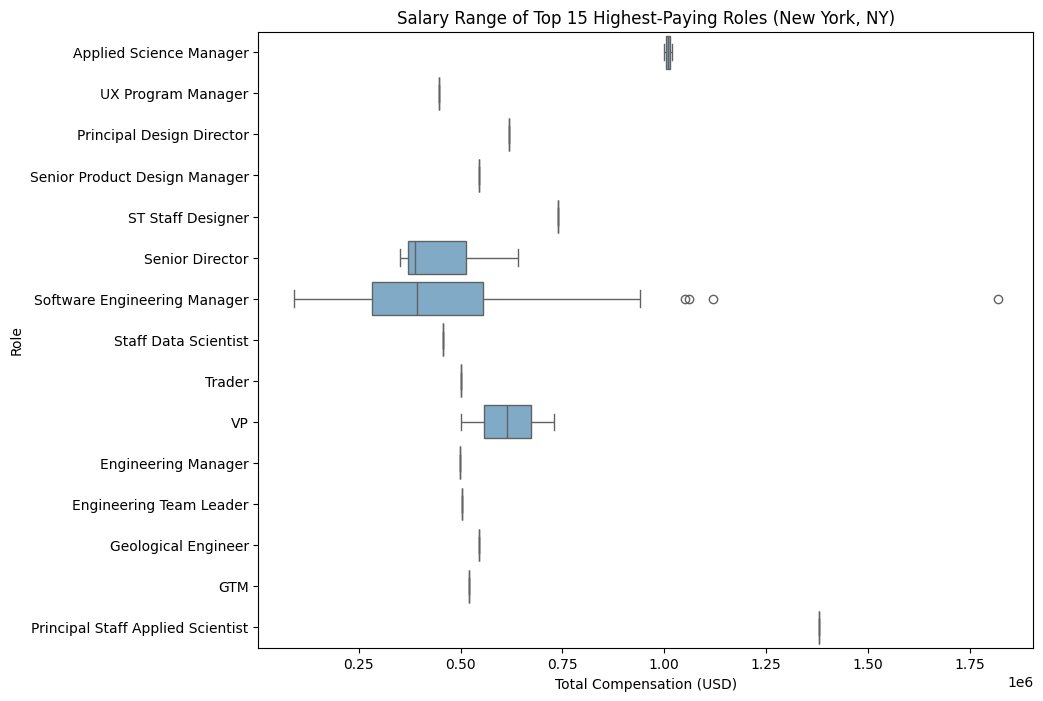

In [29]:
# New York top 15 title
ny_df = finalDf[
    (finalDf["location"] == "New York, NY") &
    (finalDf["baseSalaryCurrency"] == "USD")
].copy()

ny_df = ny_df[~(ny_df == False).any(axis=1)]

finalDf["totalComp_num"] = finalDf["totalCompensation"].replace(r'[\$,]', '', regex=True).astype(float)

top_roles = (
    ny_df.groupby("title")["totalComp_num"]
    .mean()
    .sort_values(ascending=False)
    .head(15)
    .index
)

ny_top15 = ny_df[ny_df["title"].isin(top_roles)]

plt.figure(figsize=(10,8))
sns.boxplot(
    data=ny_top15,
    x="totalComp_num",
    y="title",
    color="#74add1"
)
plt.title("Salary Range of Top 15 Highest-Paying Roles (New York, NY)")
plt.xlabel("Total Compensation (USD)")
plt.ylabel("Role")
plt.show()


**Least Paying Companies**

The chart identifies the bottom 15 least-paying companies based on average total compensation.

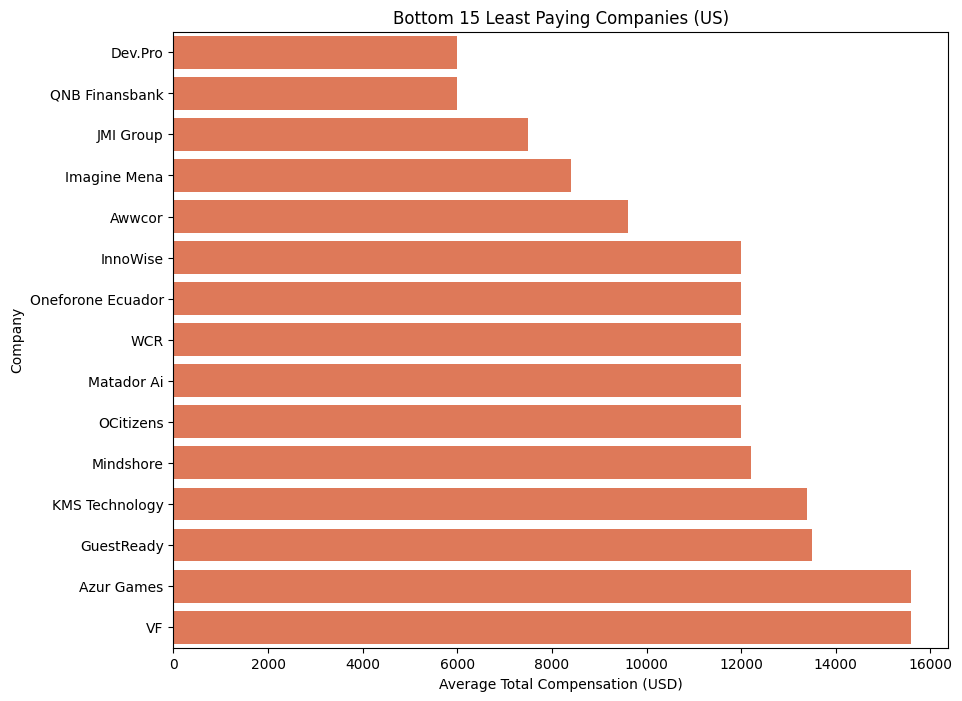

In [30]:
usDf = finalDf[
    (finalDf["baseSalaryCurrency"] == "USD")
].copy()

# remove rows containing False (cleaning rule your team used)
usDf = usDf[~(usDf == False).any(axis=1)]

company_df = (
    usDf[usDf["totalComp_num"].notna() & (usDf["totalComp_num"] > 0)]
    .groupby("company")["totalComp_num"]
    .mean()
    .sort_values()
    .head(15)
    .reset_index()
)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.barplot(
    data=company_df,
    x="totalComp_num",
    y="company",
    color="#f46d43"
)

plt.title("Bottom 15 Least Paying Companies (US)")
plt.xlabel("Average Total Compensation (USD)")
plt.ylabel("Company")
plt.show()


**Top Paying Companies**

This chart highlights the top 15 companies with the highest average total compensation.

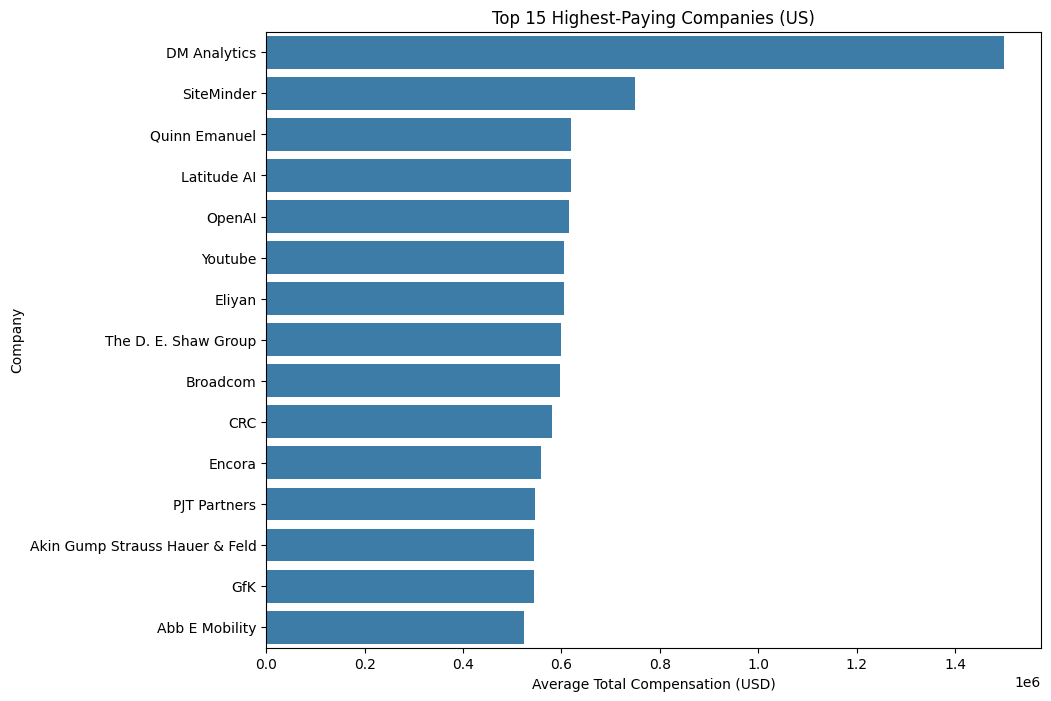

In [31]:
# Top Paying Companies
usDf = finalDf[
    (finalDf["baseSalaryCurrency"] == "USD")
].copy()

usDf = usDf[~(usDf == False).any(axis=1)]

top_company_df = (
    usDf[usDf["totalComp_num"].notna() & (usDf["totalComp_num"] > 0)]
    .groupby("company")["totalComp_num"]
    .mean()
    .sort_values(ascending=False)
    .head(15)
    .reset_index()
)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_company_df,
    x="totalComp_num",
    y="company",
    color="#2c7fb8"
)

plt.title("Top 15 Highest-Paying Companies (US)")
plt.xlabel("Average Total Compensation (USD)")
plt.ylabel("Company")
plt.show()


## Discussion and Results
**1. Top Most Common Job Titles Analysis:** (base salary)
  - **Technical Program Manager:** Highest frequency (405 records), mean salary: $190,830

  - **Software Engineering Manager:** Highest median salary, $244,000

  - **Hardware Engineer:** Maximum salary range up to $1,000,000

  - **Accountant:** Lowest median salary among top roles: $97,000

<br>

**2.   Geographic Salary Analytics:** (total compensation)


- **Highest Paying Location:** San Francisco, CA
- Maximum salary: $1,950,000 (Product Manager at Google)

- High concentration of tech leadership roles
- **Second Highest Paying Location:** Seattle, WA
- Maximum salary: $2,180,000 (Software Engineer Manager at Facebook)
- Strong presence of major tech companies
<br>

**3. Company-Specific Analysis:** (total compensation)
   - **Highest Paying Company for Accountants:** Amazon (L7 Accountant: $384,000 total compensation)

   - **Highest Paying Company for Software Engineers:** LinkedIn (Principal Staff Applied Scientist: $1,380,000)

   - **Facebook:** Offers highest overall compensation observed ($2,180,000 for Software Engineering Manager)

<br>

**4. Experience-Compensation Relationship:**
   - Moderate positive correlation between experience and compensation
   - Experience shows diminishing returns at higher levels
   - Company and role type often outweigh pure experience in compensation determination

<br>

**5. Compensation Structure Analysis:**
   - **Base Salary Range:** $20,000 - $1,000,000 among analyzed positions
   - **Stock Component:** Often comprises 50%+ of total compensation for senior technical roles
   - **Bonus Structure:** Typically 10-20% of base salary, with some companies offering significant signing bonuses

<br>


**Pre-Computed Insights:**
1. **Location-Specific Maximum:** San Francisco offers the highest local maximum ($1,950,000)
2. **Role-Specific Maximum:** Software Engineering Manager has highest overall compensation
3. **Company Leadership:** Facebook and Google dominate top compensation brackets
4. **Experience Impact:** While important, doesn't always correlate with highest compensation









### **Limitations and Considerations**
1. **Data Limitations:**
- Self-reported data may contain biases
- Limited demographic information for intersectional analysis

<br>

2. **Temporal Considerations:**
- Data represent a specific time period: from April to November 2025
- Market conditions and compensation trends evolve rapidly

<br>

3. **Industry Representation**
- Tehchnology sector over-presented in high compensation analysis
- Traditional industries may have different compensation structure not fully captured




## Conclusion

**This comprehensive anaylsis of compensation data reveals several critical insights:**
<br>

1. **Technical Dominance:** Technical leadership roles, particularly Software Engineering Manager and Technical Program Manager, have the highest compensation packages, with total compensation reaching up with $2.18 million annually.

<br>

2. **Geographic Premiums:** San Fransisco and Seattle emerge as the highest-paying regions, with compensation 2-3 times higher than national averages for comparable roles.

<br>

3. **Company Strategies:** Major technology companies (Facebook, Google, Linkedlin) dominate the high-compensation landscape, with innovative compensation structures heavily weighted toward stock-based incentives.

<br>

4. **Experience differences:** While experience generally correlates higher compensation, some high-experience roles in traditional industries show lower compensation than less-experienced roles. The experience premium varise significantly by industry and role type. This suggests that skill type and market demand may outweigth pure experience

<br>

5. **Market Dynamic:** Jobs in technology based in big tech cities earn much higher pay. Meanwhile, regular jobs in other industries are seeing only small raises.

<br>

6. **Base Salary Prediction:** ears of experience and years in the company increase the base salary, but years at level decreases it. I should consider adding more features to improve the accuracy of the prediction.



### **Practical Implications**

**For Employers** <br>
- Know the market: to pay competitivly, employers need to know exactly what other companies pay for a specific job in the specific city.
- Use company stock: giving empployees company stock is becoming crucial for hiring and kepping the best talend.
- Update pay rules: old or fixed ways of deciding pay might not work anymore when everyone is fighting to hire the same skilled workers.

**For Job Seekers** <br>
- Location matters: where you live seriously affects how much money you can earn.
- Highest Pay is in Leasdership: jobs where you manage or lead technical teams will get you the higest pay over time
- Look at the whole deal: when you get an offer, you must look at the entire package (salary, stock, and bounses), not just the base pay.

**For Policymakers (Government/Local Leaders)** <br>
- Pay shows economic health: big differences in pay show broader economic problems or trends.
- Plan iwth pay in Mind: local government need to consider how pay is changing when they make plans to improve the economy
- Share Salary Data: Making salary data open and clear helps everyone in the job market (workers, companies, and the goverment).

### **Future Research** <br>
1. Track compensation trends over multiple years
2. More detailed intersectional compensation analysis
3. Deep dive into specific sectors
4. More salary prediction algorithms

## References

- McKinney, W. (2022). Python for Data Analysis. O'Reilly Media.
- Runstone Academy. Python for Everybody - Interactive.
- NumPy Documentation. (2023). NumPy User Guide. Retrieved from https://numpy.org/doc/
- Pandas Documentation. (2023). Pandas User Guide. Retrieved from https://pandas.pydata.org/docs/
- Google Colab Research. External data: Local Files, Drive, Sheets, and Cloud Storage.  https://colab.research.google.com/notebooks/io.ipynb
- Seaborn Documentation. (2023). Statistical Data Visualization. Retrieved from https://seaborn.pydata.org/
- Hunter, J. D. (2007). Matplotlib: A 2D Graphics Environment. Computing in Science & Engineering. Retrieved from https://matplotlib.org/

- CSDN. (2020). Linear Regression. https://blog.csdn.net/iqdutao/article/details/109402570
- Datacamp. (2025). Introduction to NumPy. https://www.datacamp.com/courses/introduction-to-numpy
- Datacamp. (2021). NumPy Cheat Sheet: Data Analysis in Python. https://www.datacamp.com/cheat-sheet/numpy-cheat-sheet-data-analysis-in-python
- Datacamp. (2025). Data Manipulation with pandas. https://www.datacamp.com/courses/data-manipulation-with-pandas
- Datacamp. (2021). Pandas Cheat Sheet for Data Science in Python. https://www.datacamp.com/cheat-sheet/pandas-cheat-sheet-for-data-science-in-python

## Appendix